In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,MaxPooling2D,Conv2D,Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [2]:
train_data = tf.keras.utils.image_dataset_from_directory(
    'pepper_bell',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    # validation_split=0.2,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    # data_format=None,
    verbose=True,
)

Found 2882 files belonging to 2 classes.


In [3]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [4]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(train_data)

In [5]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [7]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from keras.applications import ResNet50
conv_base = ResNet50(
           weights = 'imagenet',
           include_top = False,
           input_shape = (128,128,3)
)


out = conv_base.output
out  = GlobalAveragePooling2D()(out)
out = Flatten()(out)
out = Dense(512, activation='relu')(out)
out = Dropout(0.2)(out)
out = Dense(256, activation='relu')(out)
out = Dropout(0.1)(out)
out = Dense(64, activation='relu')(out)
predictions = Dense(2, activation='softmax')(out)
model = Model(inputs=conv_base.input, outputs=predictions)

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,784,706 (94.55 MB)

 Trainable params: 24,731,586 (94.34 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
history = model.fit(
    x=train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=8,
)

Epoch 1/8
72/72 ━━━━━━━━━━━━━━━━━━━━ 3602s 50s/step - accuracy: 0.8026 - loss: 0.3889 - val_accuracy: 0.9861 - val_loss: 0.0552
Epoch 2/8
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9903 - loss: 0.0523 - val_accuracy: 0.9965 - val_loss: 0.0303
Epoch 3/8
72/72 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9970 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 1.6689e-04
Epoch 4/8
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.9963 - loss: 0.0098 - val_accuracy: 0.9965 - val_loss: 0.0061
Epoch 5/8
72/72 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9954 - loss: 0.0111 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 6/8
72/72 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.9986 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 1.8749e-04
Epoch 7/8
72/72 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9942 - loss: 0.0210 - val_accuracy: 0.9931 - val_loss: 0.0107
Epoch 8/8
72/72 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9979 - loss: 0.0097 - val_accuracy: 0.9965 -

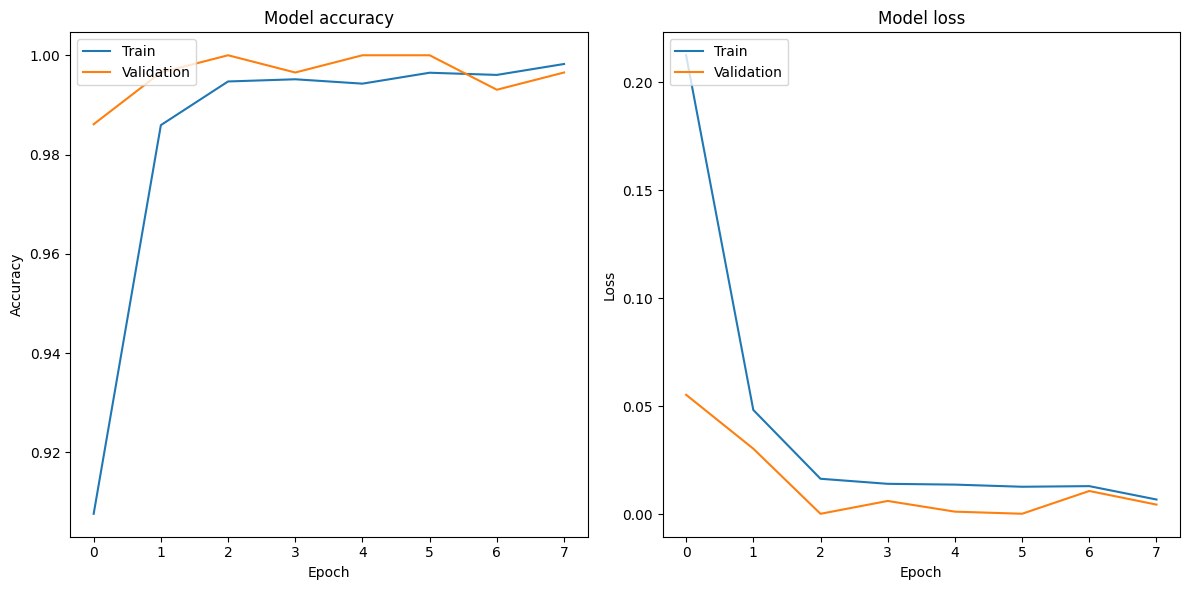

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 690ms/step - accuracy: 1.0000 - loss: 2.7618e-04


[0.00023553679056931287, 1.0]

In [19]:
model.save("pepper_bell_model.keras")

In [20]:
import json
with open("pepper_bell_hist01.json","w") as f:
    json.dump(history.history , f)

In [21]:
class_names = train_data.class_names
class_names

['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy']